<a href="https://colab.research.google.com/github/mastermindankur/stock-analysis/blob/main/bse_top_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the notebook, I am going to look at the top 100 BSE stocks by Capital Market and see which ones turned profitale or not

In [91]:
!pip install bsedata
!pip install quandl

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import quandl
import requests
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [93]:
# to be ale to view numbers in human readable format 2.058691e+08
pd.set_option('display.float_format', lambda x: '%.3f' % x)
quandl.ApiConfig.api_key = 'izbxGLp_K_zzzUJdN9sp'

**Function Name:**  profit_or_loss_sk_anku_SR_strategy.

---

**Function Inputs**: 

**Code of the Stock** - Unique Code of the Stock

**Start Date** and **End Date** constitute the date range.

**Daily Budget:** Amount on which I want to take up every trade

---


**Return Value**

**s1r1_count** - No of Trades that happened as per Support and Resistance Stratey

**forced_count** - No of Trades that we were able to Buy at Support price and forced to sell at Closing Price

**condition_not_matched_count** - Count of days where trade did not happen because our prices were not reached

**profit_s1r1** - Profit made as per Support-Resistance Strategy

**profit_forced** - Profit or Loss made as per selling forcefully at Closing Price

**net_profit_per_share** = profit_s1r1 + profit_forced. Total Profit Made

**cumulative_profit** -Total Profit Made if we had purchaed stocks as per Daily Budget

**percentage_return** - Return out of 100

**Pivot Point Calculation**

Pivot point (PP) = (High + Low + Close) / 3.

First resistance (R1) = (2 x PP) – Low.

First support (S1) = (2 x PP) – High.

Second resistance (R2) = PP + (High – Low)

Second support (S2) = PP – (High – Low)

Third resistance (R3) = High + 2(PP – Low)

Third support (S3) = Low – 2(High – PP)

**I will set the Target price in such a way, that i am will buy above the Support and will want to sell it below the Resistance.**

The following Flags are set for 'got_it':

1 - If we are able to Buy at Support+delta and Sell at Resistance-delta the same day. Successful Trade.

2 - If we are able to Buy at Support+delta but not able to sell it since the Resistance-delta price never came.

0 - If we are not able to buy at all since Support+delta price was never reached that day

When Resistance Level was hit the same day and trade happened successfully:

**Profit = Selling Price  - Buying Price**

However, when Resitance price did not hit, we are forcing to sell at Closing Price for that day. In that case:

**Profit = Closing Price - Buying Price**

In [94]:
def profit_or_loss_sk_anku_SR_strategy(code,start,end,daily_budget):
  sbi =quandl.get(code, start_date=start, end_date=end)  
  # Calculate Pivot, S1,R1,S2,R2,S3,R3
  sbi['PP']= (sbi['High']+sbi['Low']+sbi['Close'])/3
  sbi['R1']= 2*sbi['PP'] -sbi['Low']
  sbi['S1']= 2*sbi['PP'] -sbi['High']
  sbi['R2']= sbi['PP'] + (sbi['High'] - sbi['Low']) 
  sbi['S2']= sbi['PP'] - (sbi['High'] - sbi['Low']) 
  sbi['R3']= sbi['High'] + 2*(sbi['PP'] - sbi['Low'])
  sbi['S3']= sbi['Low'] - 2*(sbi['High'] - sbi['PP'])

  #No of shares worth 50,000 Rupees or daily_budget/share
  #Up and Down are the tick values
  no_of_shares=daily_budget/sbi['Open'].median()
  up= sbi['Spread H-L'].median()*.10
  down= sbi['Spread H-L'].median() *.10
  #up=1
  #down=1

  sbi['Buy']= sbi['S1'].shift(1) + up
  sbi['Sell']= sbi['R1'].shift(1) - down

  sbi['got_it'] = 0
  # if the trade happened between support and resistance levels, put 1 in ot_it column
  sbi.loc[(sbi['Buy']>sbi['Low']) & (sbi['Sell'] <sbi['High']) & (sbi['Sell']>sbi['Buy']),'got_it']=1
  # If i was able to Buy but not able to sell it becuase price did not hit resistance level, put 2 in got_it column
  sbi.loc[(sbi['Buy']>sbi['Low']) & (sbi['Sell'] >sbi['High']) ,'got_it']=2
  sbi['Profit']=0
  profit= sbi['Sell']-sbi['Buy']
  forced_profit_or_loss= sbi['Close']-sbi['Buy']

  sbi.loc[(sbi['got_it']==1) ,'Profit']=profit
  sbi.loc[(sbi['got_it']==2) ,'Profit']=forced_profit_or_loss
  
  s1r1_count= sbi[sbi['got_it']==1]['got_it'].count()
  forced_count= sbi[sbi['got_it']==2]['got_it'].count()
  condition_not_matched_count= sbi[sbi['got_it']==0]['got_it'].count()
  
  profit_forced= sbi[sbi['got_it']==2]['Profit'].sum()
  profit_s1r1=sbi[sbi['got_it']==1]['Profit'].sum()
  net_profit_per_share= sbi['Profit'].sum()
  cumulative_profit=sbi['Profit'].sum() * no_of_shares
  percentage_return=sbi['Profit'].sum()/sbi['Open'].mean() *100

  return s1r1_count,forced_count,condition_not_matched_count,profit_s1r1,profit_forced,net_profit_per_share,cumulative_profit,percentage_return

Go to the URL https://www.bseindia.com/markets/equity/EQReports/TopMarketCapitalization.aspx and find the top 100 stocks and call the function called profit_or_loss_sk_anku_SR_strategy.

By calling this I am able to get the TOP 100 stocks trading on BSE by Market Capitalization dynamically.


In [95]:
url = 'https://www.bseindia.com/markets/equity/EQReports/TopMarketCapitalization.aspx'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get(url, headers=header)
dfs = pd.read_html(r.text)
bse100= dfs[0].iloc[0:100]
bse100['Code']='BSE/BOM'+ bse100['Security Code']

Iterating through all the stocks and seeing if Profit or Loss was made in the date range.

In [96]:
# Initialising all values to Zero
#bse100['s1r1_count']=0
#bse100['forced_count']=0
#bse100['condition_not_matched_count']=0
#bse100['profit_trade_at_S1R1']=0.0
#bse100['profit_forced_sold_at_ClosingPrice']=0.0
#bse100['net_profit_per_share']=0.0
#bse100['cumulative_profit']=0.0
#bse100['percentage_return']=0.0

for i in bse100.index: 
     print(bse100['Code'][i]) 
     code= bse100['Code'][i]
     try:
       s1r1_count,forced_count,condition_not_matched_count,profit_trade_at_S1R1,profit_forced_sold_at_ClosingPrice,net_profit_per_share,cumulative_profit, percentage_return= profit_or_loss_sk_anku_SR_strategy(code,start='2020-12-01', end='2021-01-19',daily_budget=50000)

     except Exception:
      print("Am here, there was a problem with stock {x}".format(x=code))
      s1r1_count=0
      forced_count=0
      condition_not_matched_count=0
      profit_trade_at_S1R1=0
      profit_forced_sold_at_ClosingPrice=0
      net_profit_per_share=0
      cumulative_profit=0
      percentage_return=0
     
     # Setting the new value
     #data.loc[data.bidder == 'parakeet2004', 'bidderrate'] = 100
     bse100.loc[i,'s1r1_count']=s1r1_count
     bse100.loc[i,'forced_count']=forced_count
     bse100.loc[i,'condition_not_matched_count']=condition_not_matched_count
     bse100.loc[i,'profit_trade_at_S1R1']=profit_trade_at_S1R1
     bse100.loc[i,'profit_forced_sold_at_ClosingPrice']=profit_forced_sold_at_ClosingPrice
     bse100.loc[i,'net_profit_per_share']=net_profit_per_share
     bse100.loc[i,'cumulative_profit']=cumulative_profit
     bse100.loc[i,'percentage_return']=percentage_return

     #bse100['forced_count'][i]=forced_count
     #bse100['condition_not_matched_count'][i]=condition_not_matched_count
     #bse100['profit_s1r1'][i]=profit_trade_at_S1R1
     #bse100['profit_forced'][i]=profit_forced_sold_at_ClosingPrice
     #bse100['net_profit_per_share'][i]=net_profit_per_share
     #bse100['cumulative_profit'][i]=cumulative_profit
     #bse100['percentage_return'][i]=percentage_return



BSE/BOM500325
BSE/BOM532540
BSE/BOM500180
BSE/BOM500209
BSE/BOM500696
BSE/BOM500010
BSE/BOM532174
BSE/BOM500247
BSE/BOM532454
BSE/BOM500034
BSE/BOM500875
BSE/BOM532281
BSE/BOM500112
BSE/BOM500820
BSE/BOM507685
BSE/BOM532500
BSE/BOM532215
BSE/BOM500510
BSE/BOM540376
BSE/BOM500790
BSE/BOM532538
BSE/BOM541450
BSE/BOM524715
BSE/BOM532978
BSE/BOM540777
BSE/BOM500114
BSE/BOM500188
BSE/BOM500312
BSE/BOM532921
BSE/BOM532977
BSE/BOM532898
BSE/BOM500520
BSE/BOM532555
BSE/BOM532755
BSE/BOM500096
BSE/BOM500228
BSE/BOM532488
BSE/BOM530965
BSE/BOM543066
Am here, there was a problem with stock BSE/BOM543066
BSE/BOM540719
BSE/BOM500547
BSE/BOM500331
BSE/BOM500387
BSE/BOM533278
BSE/BOM500825
BSE/BOM500124
BSE/BOM532424
BSE/BOM500570
BSE/BOM505200
BSE/BOM500470
BSE/BOM509480
BSE/BOM540133
BSE/BOM532868
BSE/BOM540005
BSE/BOM532187
BSE/BOM534816
BSE/BOM540716
BSE/BOM541729
BSE/BOM500300
BSE/BOM500087
BSE/BOM500295
BSE/BOM500182
BSE/BOM539448
BSE/BOM517354
BSE/BOM532777
BSE/BOM532155
BSE/BOM500550
BSE/BOM5

Listing a stock where exception was raised since Quandl API returned null.

In [97]:
bse100[bse100['Code']=='BSE/BOM543066']

,Security Code,Security Name,Close(),Market Capitalization( Cr.),Code,s1r1_count,forced_count,condition_not_matched_count,profit_trade_at_S1R1,profit_forced_sold_at_ClosingPrice,net_profit_per_share,cumulative_profit,percentage_return
38,543066,SBI Cards and Payment Services Ltd,966.750,90925.300,BSE/BOM543066,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [98]:
bse100['percentage_return'].median()

7.418202045707768

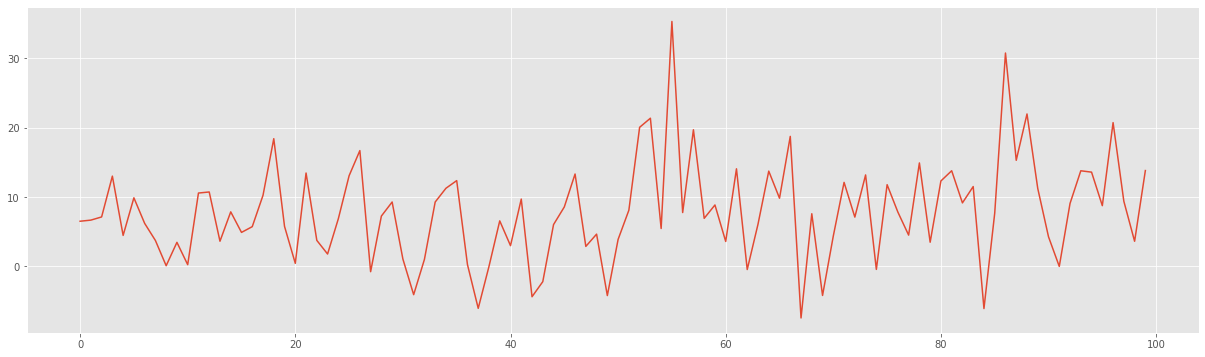

In [99]:
bse100['percentage_return'].plot(figsize=(21,6))
#bse100[bse100['percentage_return']<0]

No of Stocks that are **profitable** and not of stocks wheich were **loss-making**

In [100]:
#Count of Profit Making Stocks
bse100['net_profit_per_share'][bse100['net_profit_per_share']>0].count()

87

In [101]:
# Count of stocks that were loss making
bse100['net_profit_per_share'][bse100['net_profit_per_share']<0].count()

11

Sorting the stocks that followed the Support Resistance Stratey and listing them in descending order of return. The stock with highest return is listed on the top.

In [102]:
bse100[['Security Name','Code','s1r1_count','forced_count','condition_not_matched_count','profit_trade_at_S1R1','profit_forced_sold_at_ClosingPrice','net_profit_per_share','cumulative_profit','percentage_return']].sort_values(by='percentage_return',ascending=False)

,Security Name,Code,s1r1_count,forced_count,condition_not_matched_count,profit_trade_at_S1R1,profit_forced_sold_at_ClosingPrice,net_profit_per_share,cumulative_profit,percentage_return
55,Indus Towers Ltd,BSE/BOM534816,13.000,5.000,17.000,89.830,-3.633,86.197,17816.591,35.284
86,Adani Total Gas Ltd,BSE/BOM542066,10.000,6.000,19.000,108.050,4.520,112.570,15367.918,30.737
88,Vodafone Idea Ltd,BSE/BOM532822,8.000,7.000,20.000,2.062,0.299,2.361,11596.267,21.959
53,Larsen & Toubro Infotech Ltd,BSE/BOM540005,8.000,7.000,20.000,522.170,257.590,779.760,10830.000,21.345
96,APOLLO HOSPITALS ENTERPRISE LTD.,BSE/BOM508869,12.000,4.000,19.000,512.680,-5.537,507.143,10421.110,20.713
...,...,...,...,...,...,...,...,...,...,...
49,TATA STEEL LTD.,BSE/BOM500470,3.000,9.000,22.000,33.005,-60.143,-27.138,-2136.811,-4.202
42,SHREE CEMENT LTD.,BSE/BOM500387,5.000,9.000,20.000,1234.700,-2307.688,-1072.988,-2191.082,-4.371
37,INDIAN OIL CORPORATION LTD.,BSE/BOM530965,3.000,9.000,23.000,2.710,-8.360,-5.650,-3031.116,-6.043
84,UPL Limited,BSE/BOM512070,5.000,5.000,25.000,32.300,-60.800,-28.500,-3077.754,-6.074


In [103]:
# Saving it in an excel file
bse100[['Security Name','Code','s1r1_count','forced_count','condition_not_matched_count','profit_trade_at_S1R1','profit_forced_sold_at_ClosingPrice','net_profit_per_share','cumulative_profit','percentage_return']].to_excel('BSE100Summary.xlsx',sheet_name='xx')

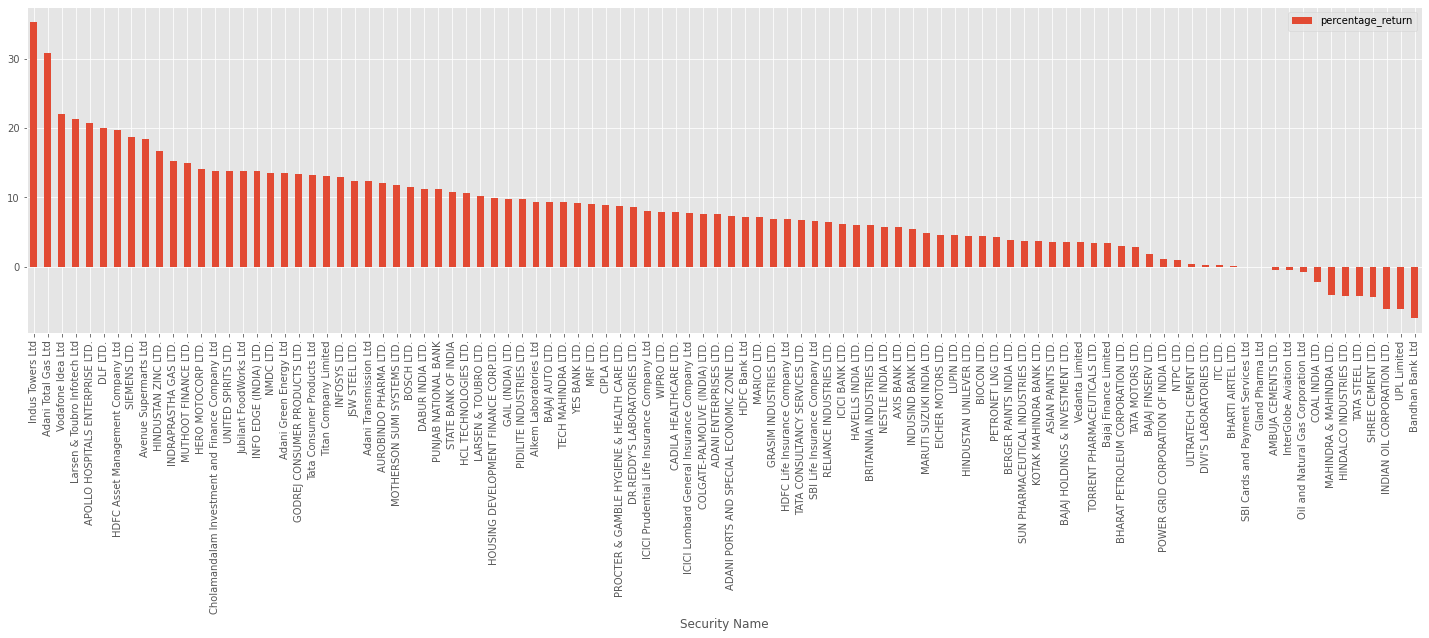

In [107]:
# Plotting the stocks and the returns in barh form
df=bse100[['Security Name','percentage_return']].sort_values(by='percentage_return',ascending=False)
df.plot.bar('Security Name','percentage_return', figsize=(25,6))